# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi
!nvcc --version

Mon Aug 19 00:28:55 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install ultralytics
# !pip install supervision
!pip install ffmpeg-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 1.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [ ]:
# import libraries
import ultralytics
from ultralytics import YOLO
import os, json, shutil

import numpy as np
import pandas as pd
from collections import defaultdict

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import ffmpeg
# import supervision as sv
import cv2

# Video Inference

In [ ]:
base_dir = '/content/drive/MyDrive/Colab Notebooks/engr5315'
video_dir = os.path.join(base_dir, 'videos')
project_dir = os.path.join(base_dir, 'runs')

custom_focal_loss_yaml = os.path.join(base_dir, 'coco-focal-loss.yaml')
best_model_path = os.path.join(project_dir + '/train5-2/weights', 'best.pt')

model = YOLO(best_model_path)

In [ ]:
# raw video paths
# raw_video1 = video_dir + '/input-video-local-street-drive-raw.mov'
# raw_video2 = video_dir + '/input-video-parking-lot-raw.mov'
# raw_video3 = base_dir + '/videos/input-video-object-tracking-raw.mov'

# input video paths - after cut
# filenames = ['video-local-street-drive',
#             'video-parking-lot',
#             'video-object-tracking']

# input_videos = [os.path.join(video_dir, 'input-' + filename + '.mov') for filename in filenames]
# output_videos = [os.path.join(video_dir, 'output-' + filename + '.avi') for filename in filenames]
# input_videos, output_videos

# trim videos to relative scenes only
# start_time = '00:00:00'
# duration =  '00:00:50'
# ffmpeg.input(raw_video1, ss=start_time, t=duration).output(input_video1).run(overwrite_output=True)

# start_time = '00:00:34'
# duration =  '00:00:50'
# ffmpeg.input(raw_video2, ss=start_time, t=duration).output(input_video2).run(overwrite_output=True)

(['/content/drive/MyDrive/Colab Notebooks/engr5315/videos/input-video-local-street-drive.mov',
  '/content/drive/MyDrive/Colab Notebooks/engr5315/videos/input-video-parking-lot.mov',
  '/content/drive/MyDrive/Colab Notebooks/engr5315/videos/input-video-object-tracking.mov'],
 ['/content/drive/MyDrive/Colab Notebooks/engr5315/videos/output-video-local-street-drive.avi',
  '/content/drive/MyDrive/Colab Notebooks/engr5315/videos/output-video-parking-lot.avi',
  '/content/drive/MyDrive/Colab Notebooks/engr5315/videos/output-video-object-tracking.avi'])

In [ ]:
conf_threshold = 0.4
iou_threshold = 0.6

results = {}

def run_video_inference(filename, task):
  source_video = os.path.join(video_dir, 'input-' + filename + '.mov')
  if task == 'detect':
    result = model.predict(source=source_video, conf=conf_threshold, iou=iou_threshold, project=project_dir, save=True, stream=True, verbose=False)

  if task == 'track':
    result = model.track(source=source_video, conf=conf_threshold, iou=iou_threshold, project=project_dir, tracker='bytetrack.yaml', save=True, stream=True, verbose=False)

  result = list(result)
  processed_video_path = result[0].save_dir + '/input-' + filename + '.avi'
  output_video_path = os.path.join(video_dir, 'output-' + filename + '.avi')

  if os.path.exists(output_video_path):
    os.remove(output_video_path)

  shutil.move(processed_video_path, output_video_path)
  print(f'{filename} - {task} - processing complete.')

  return list(result)


results[0] = run_video_inference('video-local-street-drive', 'detect')
results[1] = run_video_inference('video-parking-lot', 'detect')
results[2] = run_video_inference('video-object-tracking', 'track')

Results saved to /content/drive/MyDrive/Colab Notebooks/engr5315/runs/predict7
video-local-street-drive - detect - processing complete.
Results saved to /content/drive/MyDrive/Colab Notebooks/engr5315/runs/predict8
video-parking-lot - detect - processing complete.
requirements: Ultralytics requirement ['lapx>=0.5.2'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 25.1 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 2.7s, installed 1 package: ['lapx>=0.5.2']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

Results saved to /content/drive/MyDrive/Colab Notebooks/engr5315/runs/track
video-object-tracking - track - processing complete.


# Plot Results

In [ ]:

def plot_results(results, title):
  object_counts = []
  confidence_scores = []
  frame_numbers = []
  detections_per_frame = []
  all_detections = []

  # process results frame by frame
  for frame_number, result in enumerate(results):
    frame_object_counts = {}
    frame_detections = []
    for detection in result.boxes:
      cls = int(detection.cls)
      confidence = float(detection.conf)
      bbox = detection.xywh

      frame_detections.append((cls, confidence, bbox))
      all_detections.append((frame_number, cls, confidence, bbox))

      if cls in frame_object_counts:
        frame_object_counts[cls] += 1
      else:
        frame_object_counts[cls] = 1

      confidence_scores.append(confidence)
      frame_numbers.append(frame_number)

      # Append the frame's object counts to the list
      object_counts.append(frame_object_counts)
      detections_per_frame.append(frame_detections)


  # prepare data in df and plot them
  object_counts_df = pd.DataFrame(object_counts).fillna(0)
  object_counts_df.index.name = 'Frame'
  object_counts_df.columns.name = 'Class'

  confidence_df = pd.DataFrame({'Frame': frame_numbers, 'Confidence': confidence_scores})
  avg_confidence_per_frame = confidence_df.groupby('Frame')['Confidence'].mean()
  avg_confidence = avg_confidence_per_frame.mean()
  # window_size = 10
  # moving_avg_confidence = average_confidence_per_frame.rolling(window=window_size).mean()


  fig,ax = plt.subplots(2,2, figsize=(20,12))
  ax[0,0].plot(avg_confidence_per_frame, label='Avg Confidence per Frame', alpha=0.5)
  ax[0,0].axhline(y=avg_confidence, color='red', linestyle='--', label='Avg Confidence')
  ax[0,0].set(title='Avg Confidence Score per Frame', xlabel='Frame', ylabel='Avg Confidence')
  ax[0,0].legend()
  ax[0,0].grid(True)

  total_object_count_per_frame = object_counts_df.sum(axis=1)
  ax[0,1].plot(total_object_count_per_frame, label='Avg Confidence per Frame', alpha=0.5)
  ax[0,1].set(title='Object Count per Frame', xlabel='Frame', ylabel='Object Count')

  total_counts = object_counts_df.sum()
  class_names = results[0].names
  total_counts.index = total_counts.index.map(class_names)

  total_counts.plot(kind='bar', color='skyblue', ax=ax[1,0])
  ax[1,0].set(title='Total Object Count per Class', xlabel='Class', ylabel='Object Count')
  ax[1,0].tick_params(axis='x', rotation=45)
  ax[1,0].grid(axis='y')

  sns.scatterplot(x=total_object_count_per_frame, y=avg_confidence_per_frame, alpha=0.5, ax=ax[1,1])
  ax[1,1].set(title=' Object Count vs. Avg Confidence', xlabel='Count', ylabel='Avg Confidence')
  ax[1,1].grid(True)

  plt.suptitle(title, fontsize=15)
  plt.show()


## Detection Results Plot

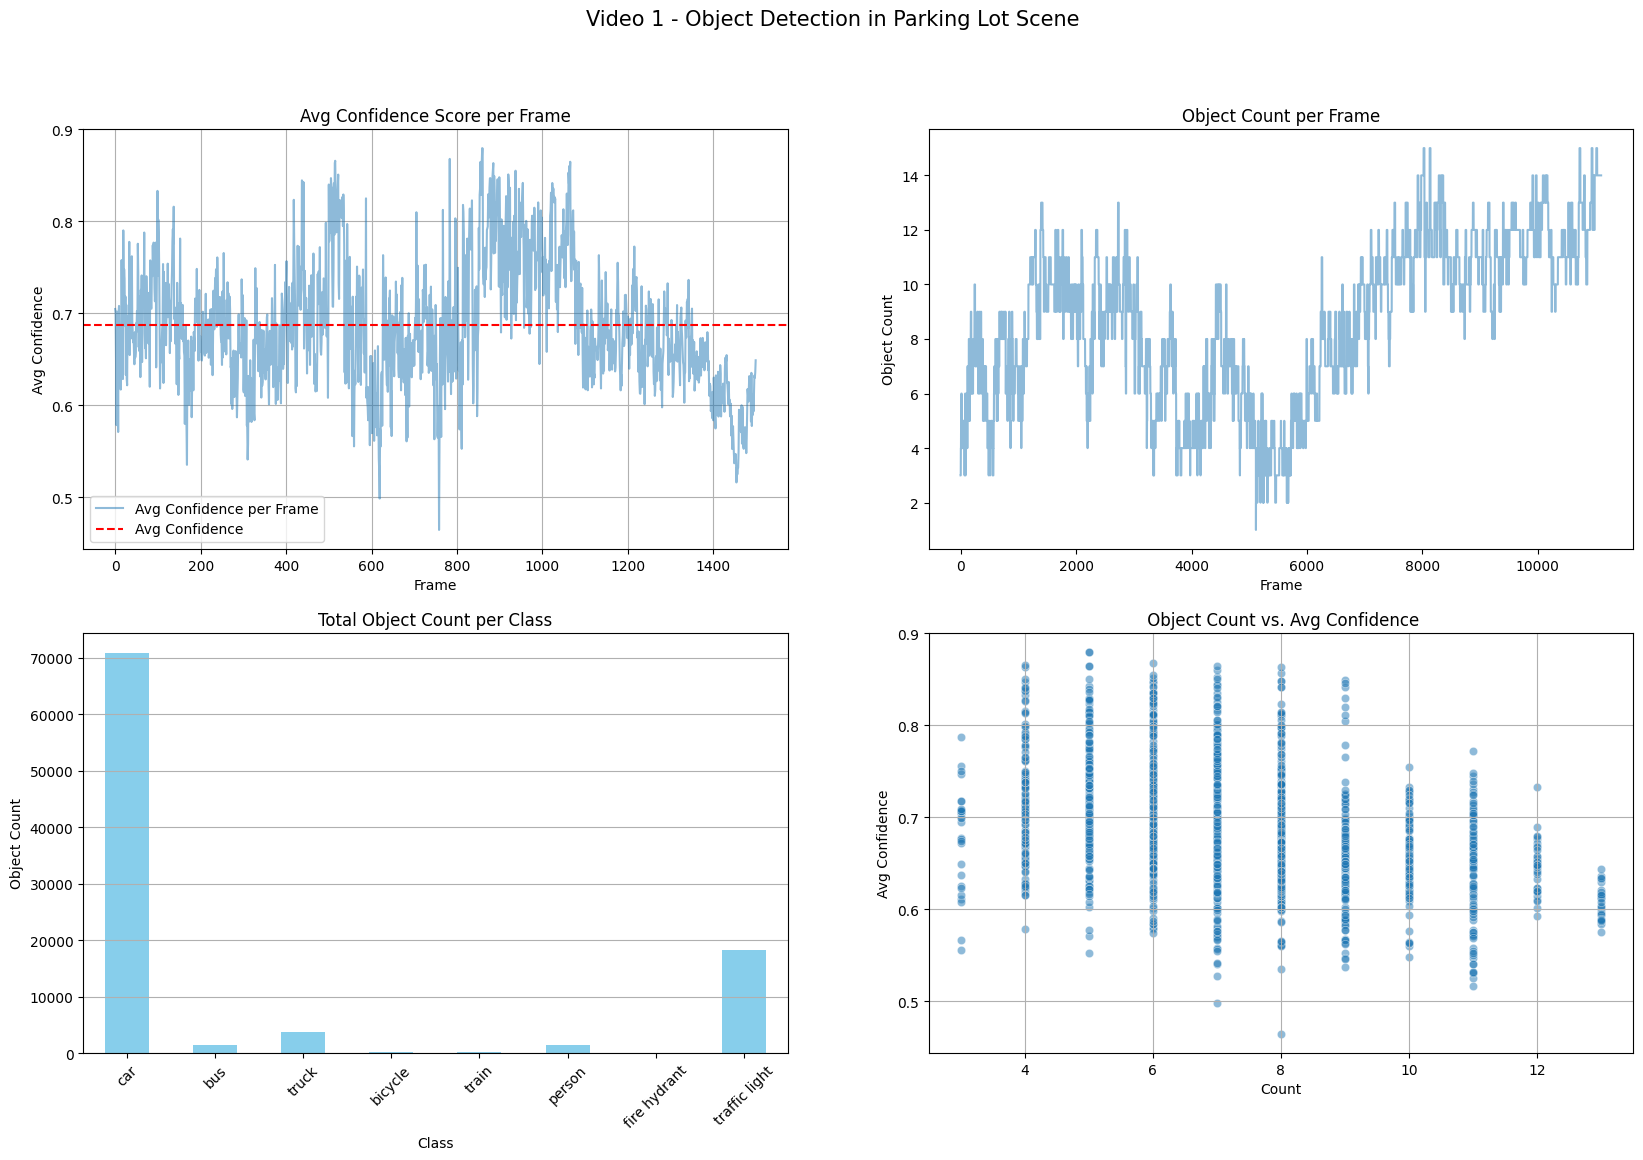

In [ ]:
plot_results(results[0], 'Video 1 - Object Detection in Parking Lot Scene')

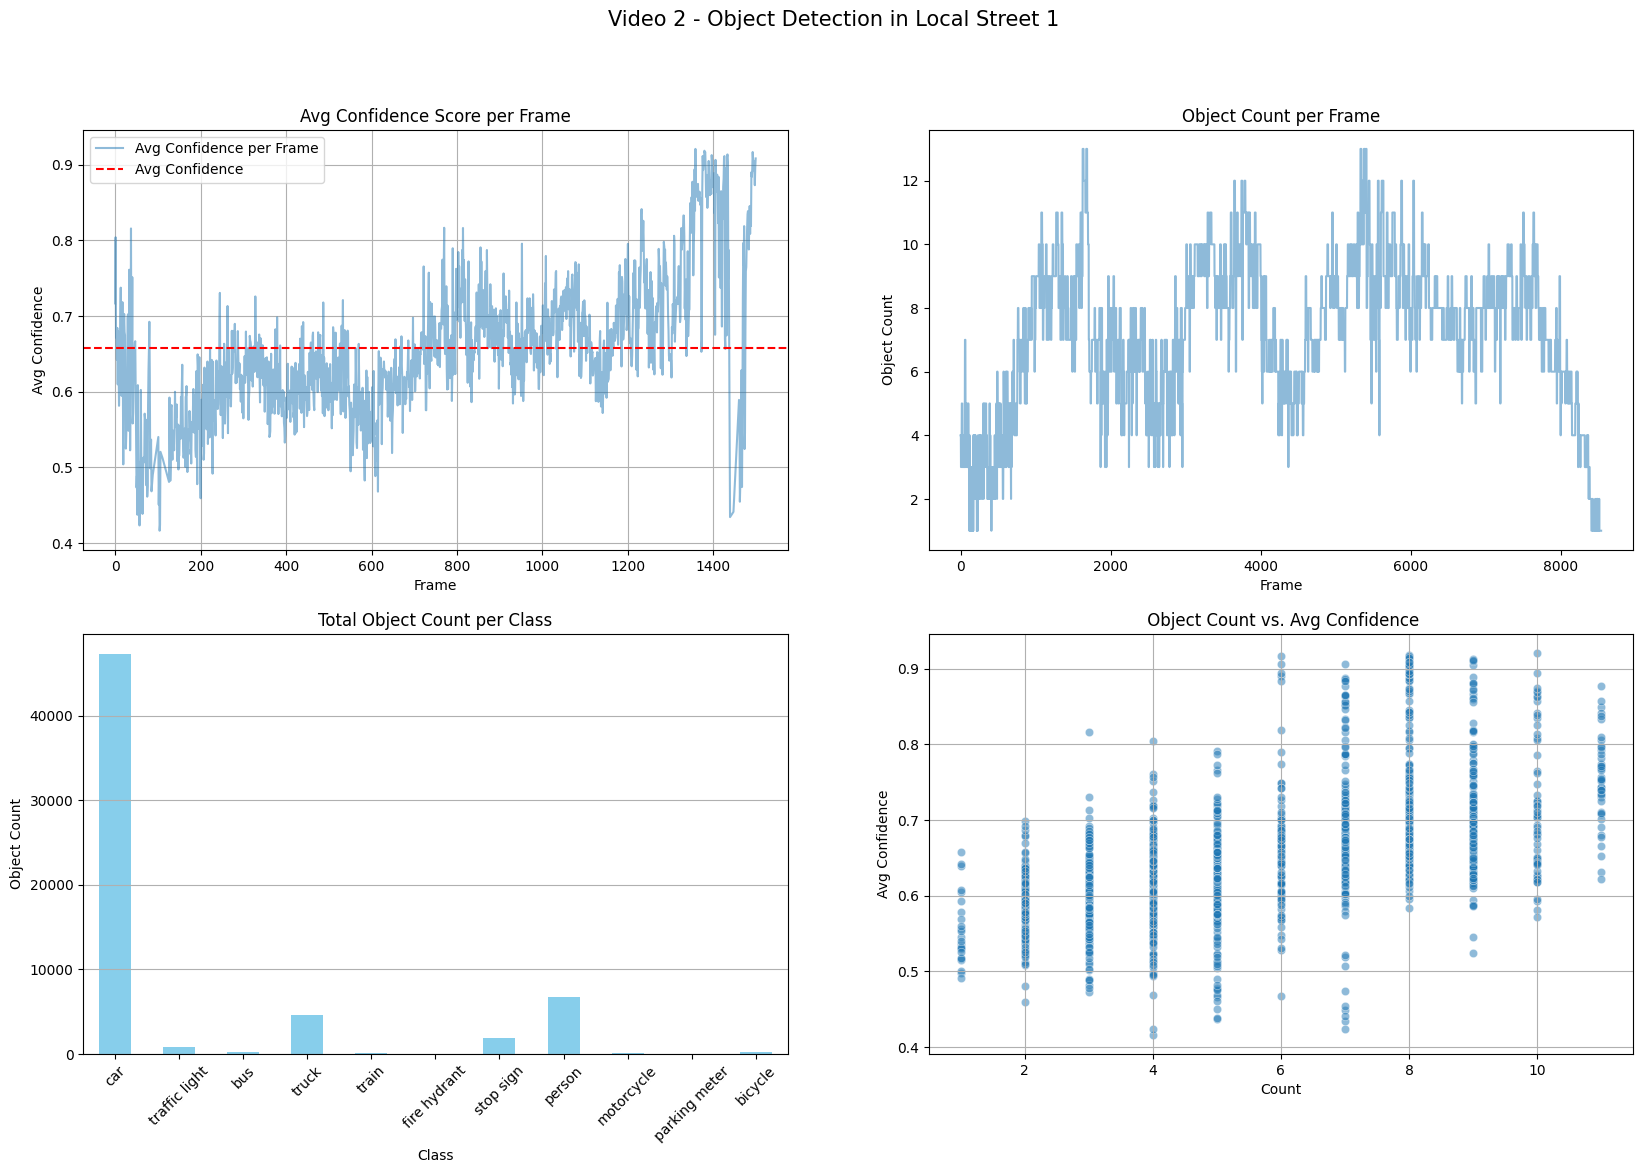

In [ ]:
plot_results(results[1], 'Video 2 - Object Detection in Local Street 1')

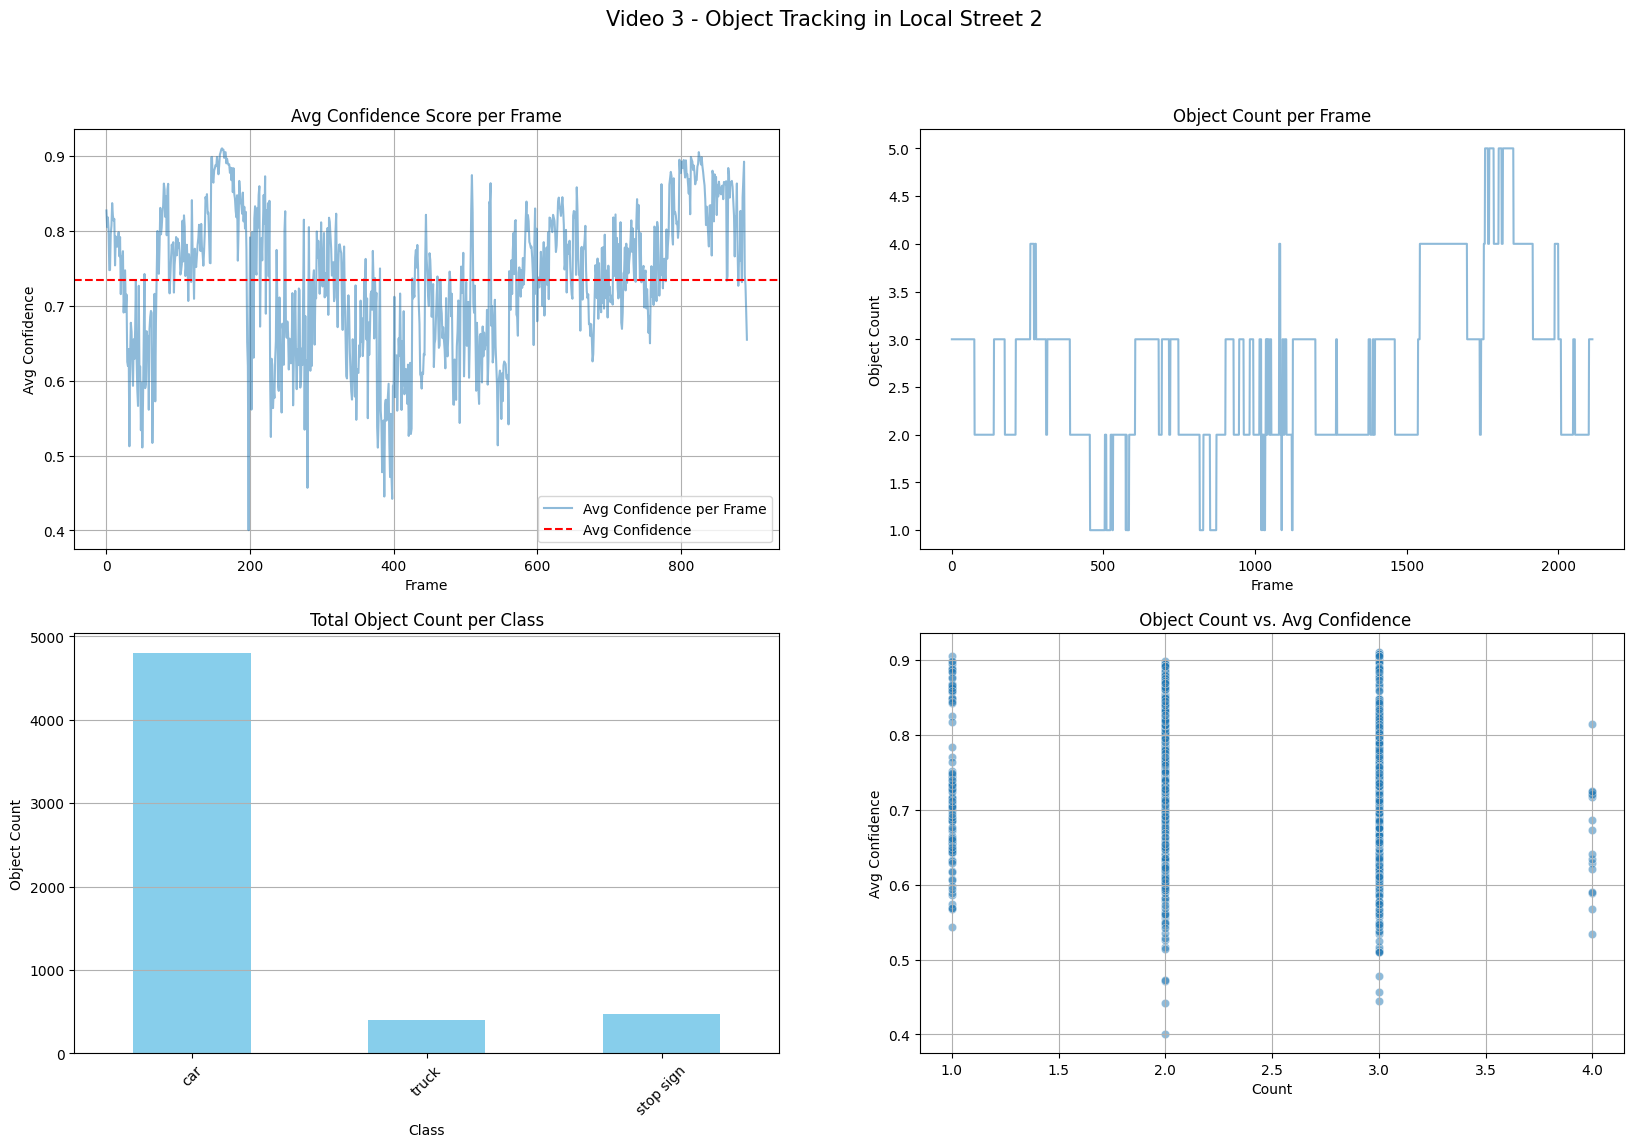

In [ ]:
plot_results(results[2], 'Video 3 - Object Tracking in Local Street 2')

## Spatial Heatmap

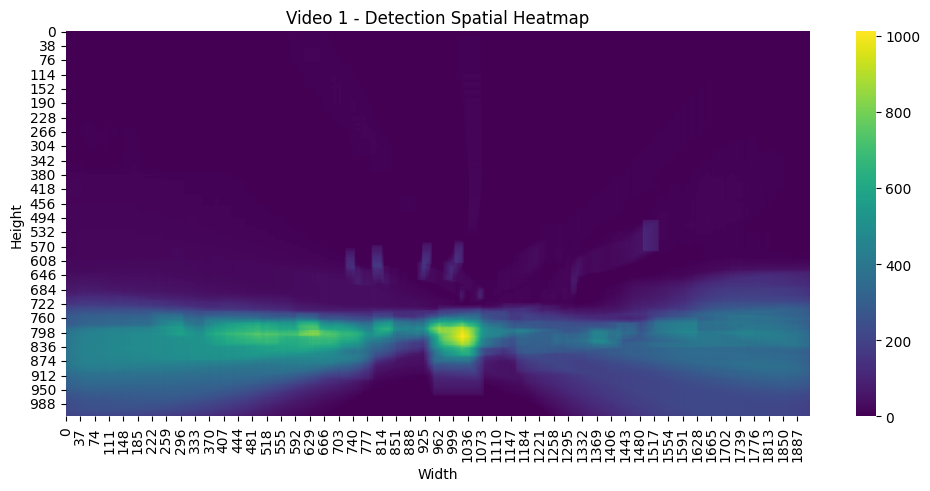

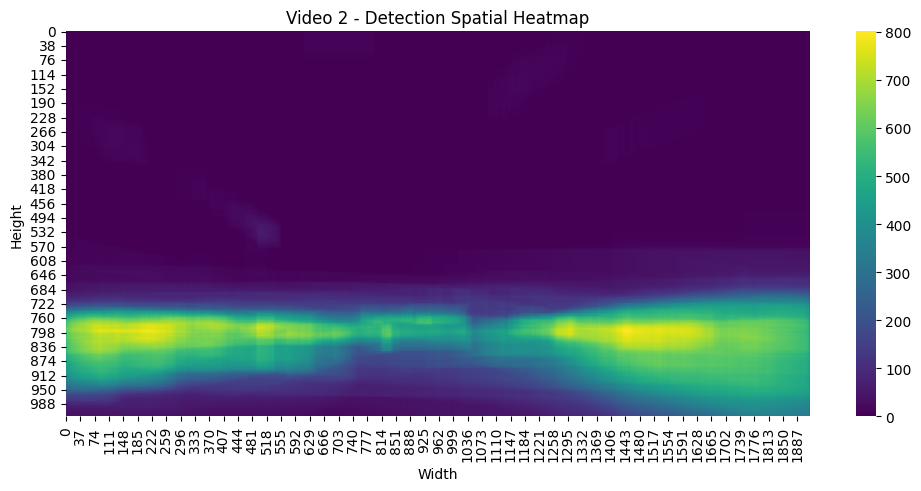

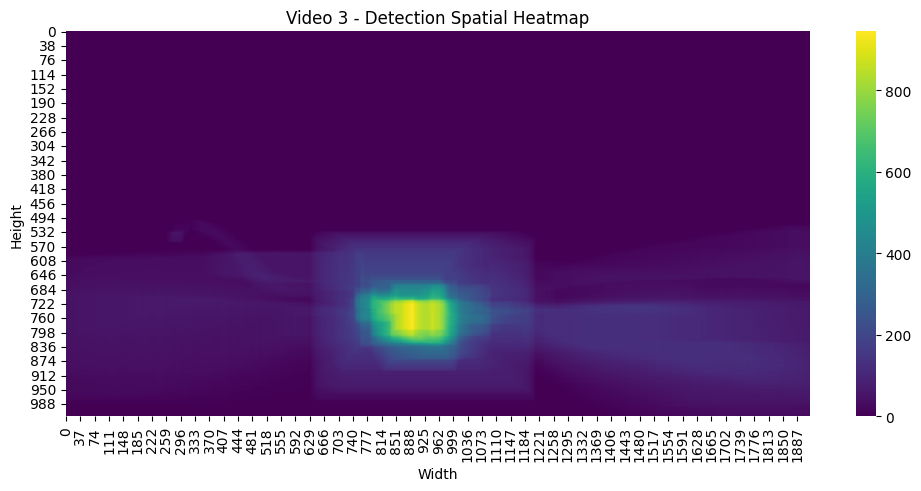

In [ ]:

def plot_spatial_heatmap(results, title):
  all_detections = []
  for frame_number, result in enumerate(results):
    for detection in result.boxes:
      cls = int(detection.cls)
      confidence = float(detection.conf)
      bbox = detection.xywh
      all_detections.append((frame_number, cls, confidence, bbox))

  height = 1020
  width = 1920
  heatmap_data = np.zeros((height, width), np.float32)

  for detection in all_detections:
      _, _, _, bbox = detection
      x, y, w, h = bbox[0]
      x1, y1, x2, y2 = int(x - w / 2), int(y - h / 2), int(x + w / 2), int(y + h / 2)
      x1, y1 = max(0, x1), max(0, y1)
      x2, y2 = min(width - 1, x2), min(height - 1, y2)
      heatmap_data[y1:y2, x1:x2] += 1

  fig, ax = plt.subplots(figsize=(12,5))
  sns.heatmap(heatmap_data, cmap='viridis', ax=ax)
  ax.set(title=title, xlabel='Width', ylabel='Height')
  plt.show()

plot_spatial_heatmap(results[0], title='Video 1 - Detection Spatial Heatmap')
plot_spatial_heatmap(results[1], title='Video 2 - Detection Spatial Heatmap')
plot_spatial_heatmap(results[2], title='Video 3 - Detection Spatial Heatmap')

## Object Trajectory

In [ ]:
detections_per_frame = []

# process results frame by frame
for frame_number, result in enumerate(results[2]):
  frame_detections = []
  for detection in result.boxes:
    cls = int(detection.cls)
    confidence = float(detection.conf)
    bbox = detection.xywh
    frame_detections.append((cls, confidence, bbox))
    detections_per_frame.append(frame_detections)

trajectories = {}
for frame_number, detections in enumerate(detections_per_frame):
  for cls, confidence, bbox in detections:
    if cls == 2:
      x, y, w, h = bbox[0]
      center_x = x + w / 2
      center_y = y + h / 2
      if frame_number not in trajectories:
          trajectories[frame_number] = []
      trajectories[frame_number].append((center_x, center_y))
trajectories

{0: [(tensor(1699.8535), tensor(863.8599)),
  (tensor(978.1520), tensor(824.6091)),
  (tensor(1104.7932), tensor(816.5780))],
 1: [(tensor(1699.8535), tensor(863.8599)),
  (tensor(978.1520), tensor(824.6091)),
  (tensor(1104.7932), tensor(816.5780))],
 2: [(tensor(1699.8535), tensor(863.8599)),
  (tensor(978.1520), tensor(824.6091)),
  (tensor(1104.7932), tensor(816.5780))],
 3: [(tensor(1719.0784), tensor(868.2936)),
  (tensor(977.2323), tensor(824.4727)),
  (tensor(1081.6782), tensor(788.4821))],
 4: [(tensor(1719.0784), tensor(868.2936)),
  (tensor(977.2323), tensor(824.4727)),
  (tensor(1081.6782), tensor(788.4821))],
 5: [(tensor(1719.0784), tensor(868.2936)),
  (tensor(977.2323), tensor(824.4727)),
  (tensor(1081.6782), tensor(788.4821))],
 6: [(tensor(1736.9797), tensor(870.5250)),
  (tensor(976.8602), tensor(824.7504)),
  (tensor(1097.8141), tensor(802.0347))],
 7: [(tensor(1736.9797), tensor(870.5250)),
  (tensor(976.8602), tensor(824.7504)),
  (tensor(1097.8141), tensor(802.0

<ipython-input-30-0f7c099abe83>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')  # Choose a color map
<ipython-input-30-0f7c099abe83>:14: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Frame Number')


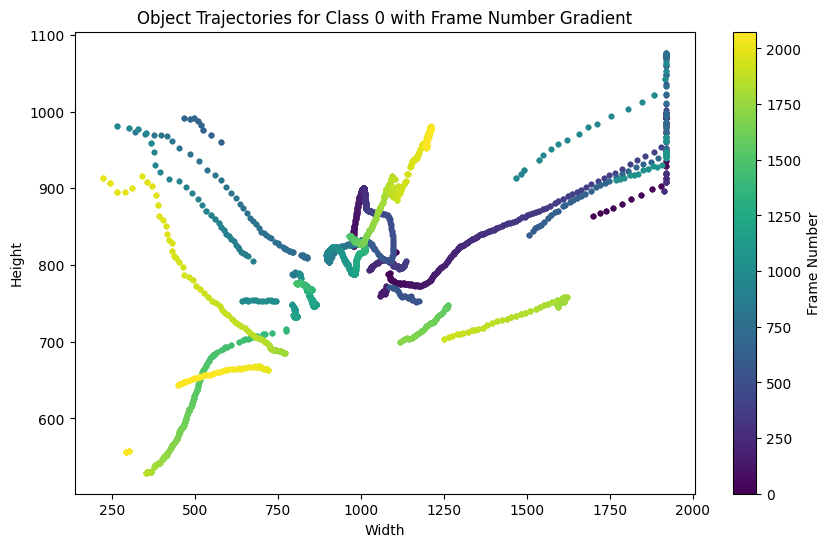

In [ ]:

plt.figure(figsize=(10, 6))
norm = plt.Normalize(0, len(trajectories))
cmap = plt.cm.get_cmap('viridis')

for frame_number, centers in trajectories.items():
    for center_x, center_y in centers:
        plt.scatter(center_x, center_y, color=cmap(norm(frame_number)), s=10)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, label='Frame Number')

plt.title('Object Trajectories for Class 0 with Frame Number Gradient')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()

In [ ]:
import random
random.seed(42)

all_detections = []
trajectories = {}
for frame_number, result in enumerate(results[2]):
    for detection in result.boxes:
        cls = int(detection.cls)
        confidence = float(detection.conf)
        bbox = detection.xywh
        track_id = int(detection.id)

        all_detections.append((frame_number, cls, confidence, bbox, track_id))
        x, y, w, h = bbox[0]
        center_x = x + w / 2
        center_y = y + h / 2

        if track_id not in trajectories:
            trajectories[track_id] = []
        trajectories[track_id].append((center_x, center_y))

track_ids = list(trajectories.keys())
colors = plt.cm.get_cmap('tab20', len(track_ids))


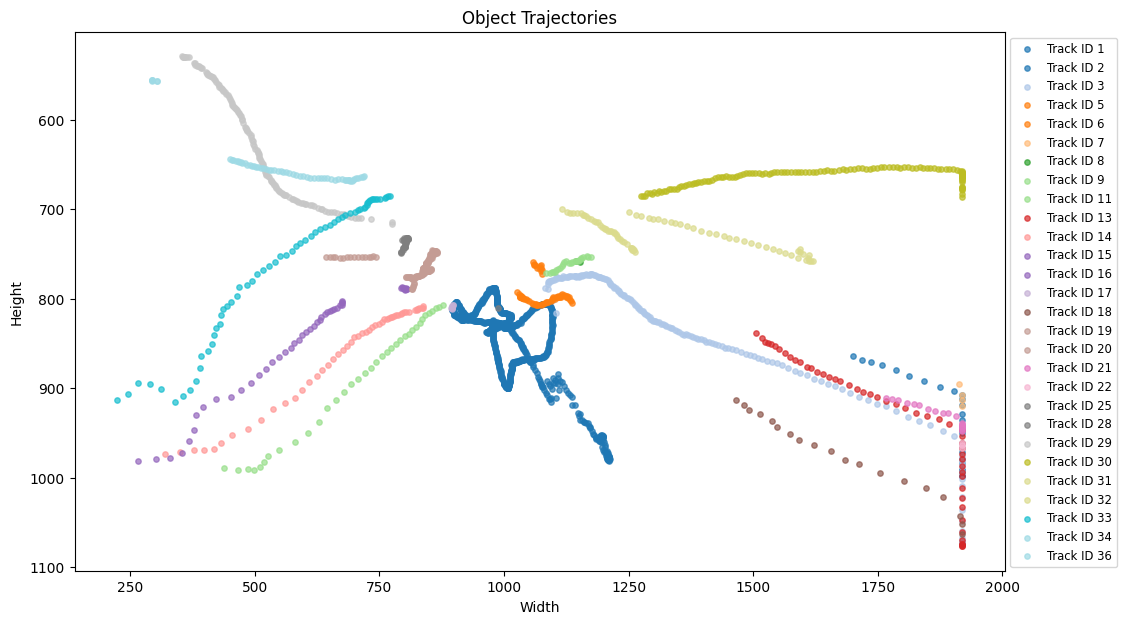

In [ ]:
plt.figure(figsize=(12,7))

for i, track_id in enumerate(track_ids):
    centers = trajectories[track_id]
    centers_x, centers_y = zip(*centers)
    plt.scatter(centers_x, centers_y, color=colors(i), label=f'Track ID {track_id}', s=15, alpha=0.7)

plt.gca().invert_yaxis()
plt.title('Object Trajectories')
plt.xlabel('Width')
plt.ylabel('Height')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
plt.show()

# Speed Evaluation

In [ ]:
def calculate_processing_speed(results):

  total_fps = []
  preprocess_time, inference_time, postprocess_time = 0, 0, 0

  for result in results:
    speed = result.speed
    total_time = ( speed['preprocess'] + speed['inference'] + speed['postprocess'] ) / 1000
    preprocess_time += speed['preprocess']
    inference_time += speed['inference']
    postprocess_time += speed['postprocess']
    fps = 1 / total_time  # fps = reciprocal of processing time
    total_fps.append(fps)

  processing_speed = {
    'average_fps': sum(total_fps) / len(total_fps),
    'preprocess': preprocess_time / 1000,
    'inference': inference_time / 1000,
    'postprocess': postprocess_time / 1000
  }

  # average_fps = sum(total_fps) / len(total_fps)
  # print(f"FPS ={average_fps:.2f}")
  return processing_speed



In [ ]:
# calculate_processing_speed(results[0])
# calculate_processing_speed(results[1])
# calculate_processing_speed(results[2])

processing_speeds = []
for i in range(len(results)):
  processing_speed = calculate_processing_speed(results[i])
  processing_speeds.append(processing_speed)

df = pd.DataFrame(processing_speeds)
df

,average_fps,preprocess,inference,postprocess
0,70.410984,3.239008,16.111121,1.989020
1,70.029067,3.305704,16.215398,1.969717
2,69.140925,2.040733,9.657575,1.249052


Average FPS: 69.14


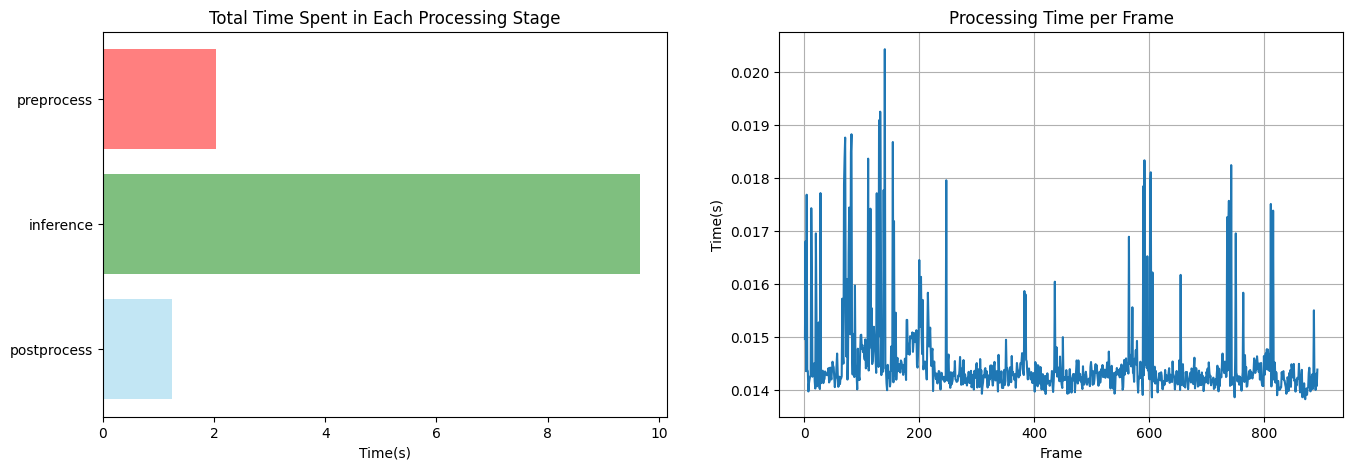

In [ ]:
# speed_data = {}
total_fps = []
preprocess_time, inference_time, postprocess_time = 0, 0, 0

for result in results[2]:
  speed = result.speed
  total_time = ( speed['preprocess'] + speed['inference'] + speed['postprocess'] ) / 1000
  preprocess_time += speed['preprocess']
  inference_time += speed['inference']
  postprocess_time += speed['postprocess']
  fps = 1 / total_time
  total_fps.append(fps)

speed_data = {
  'preprocess': preprocess_time / 1000,
  'inference': inference_time / 1000,
  'postprocess': postprocess_time / 1000
}

average_fps = sum(total_fps) / len(total_fps)
print(f"Average FPS: {average_fps:.2f}")

# plot
fig, ax = plt.subplots(1,2, figsize=(16,5))
# ax[0].barh(list(speed_data.keys()), list(speed_data.values()) , color=['skyblue', 'green', 'red'], alpha=0.5)
# ax[0].set(title='Total Time Spent in Each Processing Stage', xlabel='Time(s)')

# stages = ['preprocess', 'inference', 'postprocess']
stages = ['postprocess', 'inference', 'preprocess']
times = [speed_data[stage] for stage in stages]

# Plot the bars in the correct order
ax[0].barh(stages, times, color=['skyblue', 'green', 'red'], alpha=0.5)
ax[0].set(title='Total Time Spent in Each Processing Stage', xlabel='Time(s)')



total_processing_times = [(r.speed['preprocess'] + r.speed['inference'] + r.speed['postprocess']) / 1000 for r in results[2]]
frames = range(1, len(results[2]) + 1)

ax[1].plot(frames, total_processing_times)
ax[1].set(title='Processing Time per Frame', xlabel='Frame', ylabel='Time(s)')
ax[1].grid(True)
plt.show()
